Trying running SEDs on model 3 with different dust parameters to those the simulation was run with.  At the moment trying grain size varing from 0.05-1µm as opposed to the 0.05-0.25 used in the dynamics.  This is to see if the increased opacity at 1~5µm gives the SED the gradually rising flux between 1-20 µm seen by MSX in MYSOs

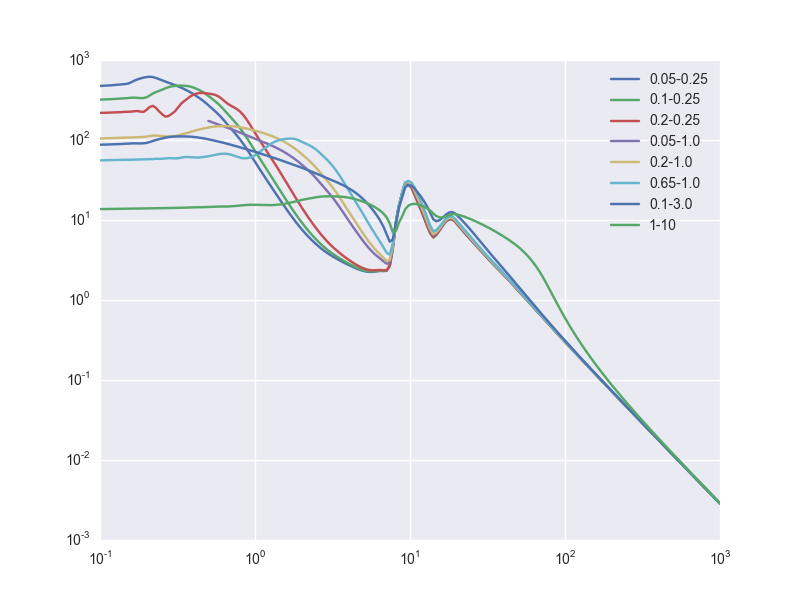

In [2]:
from IPython.display import Image
Image(filename='opacities.png')

There is some  evidence from 3-4µm emssion suggesting that larger grains (0.5-1.5 maximum size) are present around MYSOs (Steinacker2015)

The line crashes have now been fixed by tim (an aditional flag of modelwashydro set to T is needed) the models were not providing velocities in the corners of the cube causing the line run to crash.  

Currently queuing a run to try this out on <sup>13</sup>CO

However the fix seems to have broken the fixed LTE line modeling (though I'm not confident they were working anyway) 

Currently trying to figure out what would be the best way to implement line driving in torus. The best way I think would be to add in an opacity which would provide the radation pressure. However to do this we need to go from the electron scattering optical depth σ<sub>e</sub>ρ<sup>dr</sup>/<sub>dv</sub> to the line optical depth 𝜅<sub>l</sub>ρ<sup>dr</sup>/<sub>dv</sub>

Given $\frac{\Delta E}{E}=-exp[-\tau]$ and that $\frac{\Delta E}{dt} = \frac{\bf a . l}{dt} = {\bf a . u}$ then assuming the energy lost by the photons is equal to the change in energy of the gas we can use the line driving acceleration from CAK $a=\frac{\sigma_e F}{\mu c} kt^{-\alpha} $ to construct :  
$$\tau = - \ln \left( \frac{\left|\bf F . u \right|}{E} \frac{\sigma_e dt}{\mu c}  k t^{-\alpha} \right) $$  

Where ${\bf F}$ is the photon packet flux, $E$ is its energy and ${\bf u}$ is the velocity of the gas and t is the CAK optical depth parameter $t=\sigma_e v_{th} \rho \left|\frac{dv}{dl}\right|^{-1}$ with $l$ along the photon propagation direction.  
$\frac{F}{E}$ is a dificult quantity to describe when talking about individual photons and discrete volume cells, maybe should just use (cell length)<sup>-2</sup>?  

Spoken to Tim about it and ${\bf F}$ and $E$ are constant for individual photon packets, the $l^{-2}$ comes in the fact that as you move away from the source less packets on averge reach any given cell.  So $\frac{F}{E/dt}$ is just the normalised photon propagation direction, and we have:
$$\tau = - \ln \left( \left|\bf \hat u_\gamma . u_g \right| \frac{\sigma_e}{\mu c}  k t^{-\alpha} \right) $$  


Two programming jobs to do:   
Firstly implement the amr unrefine method into the start of the line radative transfer routine.  Using a density and density gradient cut, degrade the resolution in low density and/or slowly changing (in space) density cells as they are not going to be contributing much to the emission.  The AMR unrefine method is unrefineCells in hydrodynamics.F90, this recurses down until it gets to a node where all the contained nodes are leaves



Secondly implement the line driving (as detailed above) into a module to be included into hydrodynamics. TauSob in integratePath.f90 is an example of calculating a Sobolev optical depth (and escape probability) for a line photon, this can be adapted for calculing the tau from the CAK line ensemble.